In [1]:
%load_ext autoreload
%env SPARK_HOME=/usr/hdp/current/spark2-client

import findspark
findspark.init()

print('findspark initialized ...')

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, column, max, min

spark = SparkSession.builder.appName('mlonspark')\
    .config('spark.executor.instances', '7')\
    .getOrCreate()

print('pyspark ready ...')

env: SPARK_HOME=/usr/hdp/current/spark2-client
findspark initialized ...
pyspark ready ...


In [2]:
df = spark.read.load("/data/lastfm-dataset-360K/data-final.parquet")
df.printSchema()

root
 |-- userHash: string (nullable = true)
 |-- artistName: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- users-userHash: string (nullable = true)
 |-- artists-artistId: integer (nullable = true)
 |-- artists-artistName: string (nullable = true)
 |-- listenCount: float (nullable = true)



In [3]:
print("pocet hodnoceni = %d" % df.where(col("listenCount") == 0).count())

pocet hodnoceni = 1


In [4]:
from pyspark.sql.functions import min, max, avg

In [5]:
df.select(min("listenCount"), max("listenCount"), avg("listenCount")).show()

+----------------+----------------+------------------+
|min(listenCount)|max(listenCount)|  avg(listenCount)|
+----------------+----------------+------------------+
|             0.0|        419157.0|215.18544093128762|
+----------------+----------------+------------------+



In [6]:
from pyspark.sql import DataFrameStatFunctions as statFunc
statFunc(df).approxQuantile("listenCount", [0.05, 0.95], 0.001)

[6.0, 760.0]

In [7]:
from pyspark.sql.functions import variance, stddev

In [8]:
df.select(variance("listenCount"), stddev("listenCount")).show()

+---------------------+------------------------+
|var_samp(listenCount)|stddev_samp(listenCount)|
+---------------------+------------------------+
|   377546.34187644144|       614.4479976991067|
+---------------------+------------------------+



In [9]:
from pyspark.sql.functions import skewness, kurtosis

In [10]:
df.select(skewness("listenCount"), kurtosis("listenCount")).show()

+---------------------+---------------------+
|skewness(listenCount)|kurtosis(listenCount)|
+---------------------+---------------------+
|     91.8743655028596|   30874.340738570303|
+---------------------+---------------------+



In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_hist(dataframe, **model_kargs):    
    rdd = dataframe.select("listenCount").rdd.map(lambda v : v[0])
    histRdd = rdd.histogram(100)
    plt.figure(figsize=(16,4))
    plt.plot(histRdd[0][1:], histRdd[1], "g-", linewidth=2)
    plt.ylabel("počet hodnocení", fontsize=18)
    plt.xlabel("počet poslechů", fontsize=18)

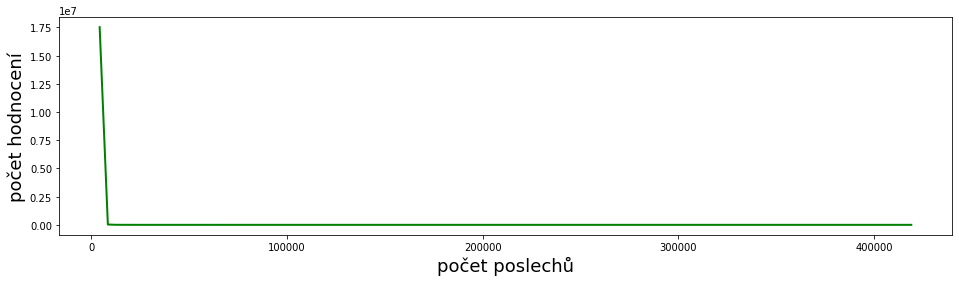

In [12]:
plot_hist(df)

In [13]:
from pyspark.sql import DataFrameStatFunctions as statFunc
quantiles = statFunc(df).approxQuantile("listenCount", [0.05, 0.95], 0.001)
quantiles

[6.0, 760.0]

In [14]:
dfFiltered = df.where(col("listenCount") > quantiles[0]).where(col("listenCount") < quantiles[1])
dfFiltered.count()                                                                                      
dfFiltered.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered.parquet")

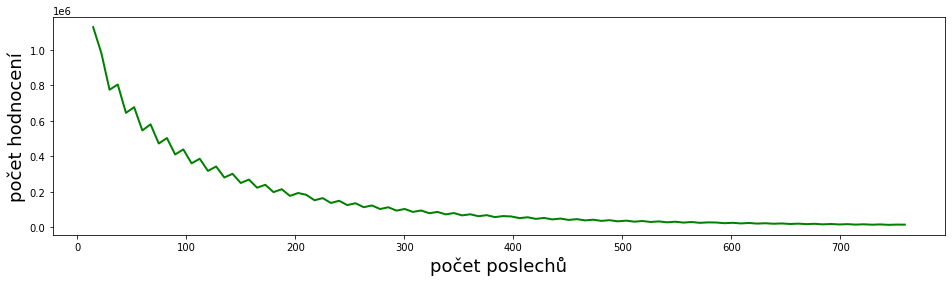

In [15]:
plot_hist(dfFiltered)

In [16]:
train, test = dfFiltered.randomSplit([0.7, 0.3])
train.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-train.parquet")
test.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-test.parquet")

In [17]:
dfFiltered.select(min("listenCount"), max("listenCount"), avg("listenCount")).show()
dfFiltered.select(variance("listenCount"), stddev("listenCount")).show()

+----------------+----------------+------------------+
|min(listenCount)|max(listenCount)|  avg(listenCount)|
+----------------+----------------+------------------+
|             7.0|           759.0|150.22779104352614|
+----------------+----------------+------------------+

+---------------------+------------------------+
|var_samp(listenCount)|stddev_samp(listenCount)|
+---------------------+------------------------+
|   23448.431099488986|      153.12880558369474|
+---------------------+------------------------+



In [18]:
mean = dfFiltered.select(avg("listenCount")).collect()[0][0]
stdDev = dfFiltered.select(stddev("listenCount")).collect()[0][0]

def zscore(listenCount, **model_kargs):
    return (listenCount - mean)/stdDev
    
dfStd = dfFiltered.withColumn("stdCount", zscore(dfFiltered.listenCount))

In [19]:
dfStd.show(10)
dfStd.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std.parquet")

+--------------------+--------------------+------+--------------------+----------------+--------------------+-----------+-------------------+
|            userHash|          artistName|userId|      users-userHash|artists-artistId|  artists-artistName|listenCount|           stdCount|
+--------------------+--------------------+------+--------------------+----------------+--------------------+-----------+-------------------+
|7db053d7e66047b4b...|   angels & airwaves|247243|7db053d7e66047b4b...|          137758|   angels & airwaves|       12.0| -0.902689670415902|
|7db053d7e66047b4b...|        jack johnson|247243|7db053d7e66047b4b...|          193045|        jack johnson|       12.0| -0.902689670415902|
|7db053d7e66047b4b...|the smashing pump...|247243|7db053d7e66047b4b...|          288200|the smashing pump...|       12.0| -0.902689670415902|
|7db053d7e66047b4b...|        jimi hendrix|247243|7db053d7e66047b4b...|           83478|        jimi hendrix|       11.0|-0.9092201203608892|
|7db05

In [20]:
dfStd = spark.read.load("/data/lastfm-dataset-360K/data-filtered-std.parquet")
dfStd.printSchema()

root
 |-- userHash: string (nullable = true)
 |-- artistName: string (nullable = true)
 |-- userId: integer (nullable = true)
 |-- users-userHash: string (nullable = true)
 |-- artists-artistId: integer (nullable = true)
 |-- artists-artistName: string (nullable = true)
 |-- listenCount: float (nullable = true)
 |-- stdCount: double (nullable = true)



In [21]:
dfStd.select(min("stdCount")).show()
stdMin = dfStd.select(min("stdCount")).collect()[0][0]
stdMin

+-------------------+
|      min(stdCount)|
+-------------------+
|-0.9353419201408382|
+-------------------+



-0.9353419201408382

In [22]:
from pyspark.sql.functions import variance, stddev
dfStd.select(variance("stdCount"), stddev("stdCount")).show()

+------------------+---------------------+
|var_samp(stdCount)|stddev_samp(stdCount)|
+------------------+---------------------+
|1.0000000000000049|   1.0000000000000024|
+------------------+---------------------+



In [23]:
absStdMin = abs(stdMin)
print(absStdMin)

def shift(stdCount, **model_kargs):
    return stdCount + absStdMin

dfStdPos = dfStd.withColumn("stdCountPos", shift(dfStd.stdCount))
dfStdPos.show(10)
dfStdPos.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos.parquet")

0.9353419201408382
+--------------------+--------------------+------+--------------------+----------------+--------------------+-----------+-------------------+--------------------+
|            userHash|          artistName|userId|      users-userHash|artists-artistId|  artists-artistName|listenCount|           stdCount|         stdCountPos|
+--------------------+--------------------+------+--------------------+----------------+--------------------+-----------+-------------------+--------------------+
|7db053d7e66047b4b...|   angels & airwaves|247243|7db053d7e66047b4b...|          137758|   angels & airwaves|       12.0| -0.902689670415902| 0.03265224972493619|
|7db053d7e66047b4b...|        jack johnson|247243|7db053d7e66047b4b...|          193045|        jack johnson|       12.0| -0.902689670415902| 0.03265224972493619|
|7db053d7e66047b4b...|the smashing pump...|247243|7db053d7e66047b4b...|          288200|the smashing pump...|       12.0| -0.902689670415902| 0.03265224972493619|
|7d

In [24]:
train, test = dfStdPos.randomSplit([0.7, 0.3])

train.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos-train.parquet")
test.write.mode("overwrite").save("/data/lastfm-dataset-360K/data-filtered-std-pos-test.parquet")